# Ataques Adversariais: Comprometendo Sistemas Baseados em Machine Learning

## Importações

In [13]:
# Import libraries
import numpy as np
from PIL import Image, ImageOps  # Install pillow instead of PIL
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

# Import tensorflow and keras libraries
import tensorflow as tf
from keras.models import load_model  # TensorFlow is required for Keras to work

## Funções Úteis

In [14]:
# Preprocess image so that it can be inputted to MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Load and preprocess image
def loadAndPreprocessImage(image_path):
  image = Image.open(image_path)
  image = image.convert("RGB")
  image = preprocess(image)
  return image

# Print image and its class and score if they exist
def printImage(image, class_name=None, confidence_score=None, eps=None):
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
  if((class_name == None) and (eps != None)):
    plt.title('Epsilon: {:0.3f}'.format(eps))
  elif((class_name != None) and (eps == None)):
    plt.title('Classe: {} Confiança: {}'.format(class_name, confidence_score))
  elif((class_name != None) and (eps != None)):
    plt.title('Epsilon: {:0.3f}\nClasse: {} Confiança: {}'.format(eps, class_name, confidence_score))
  plt.show()

# Classify sample using a pretrained model
def classifySample(image, pretrained_model):
  image_probs = pretrained_model.predict(image)
  index = np.argmax(image_probs)
  class_name = decode_predictions[index]
  confidence_score = image_probs[0][index]
  return image_probs, class_name, confidence_score

## Mostrando as imagens

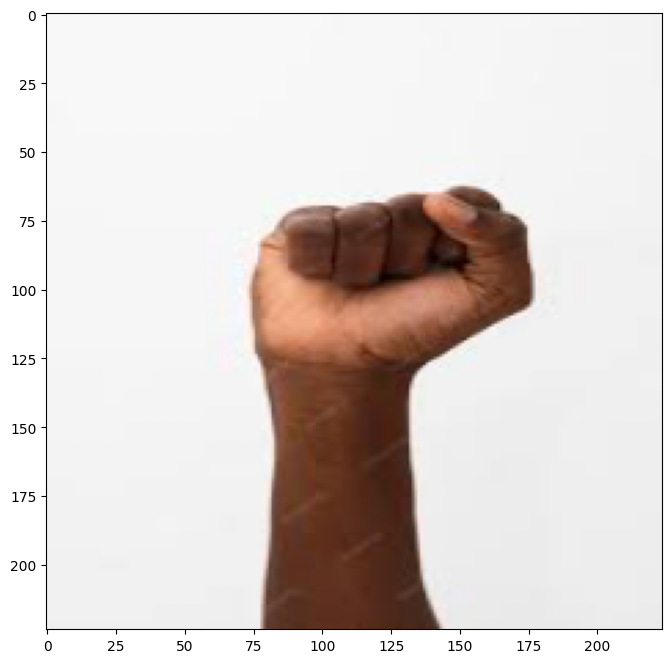

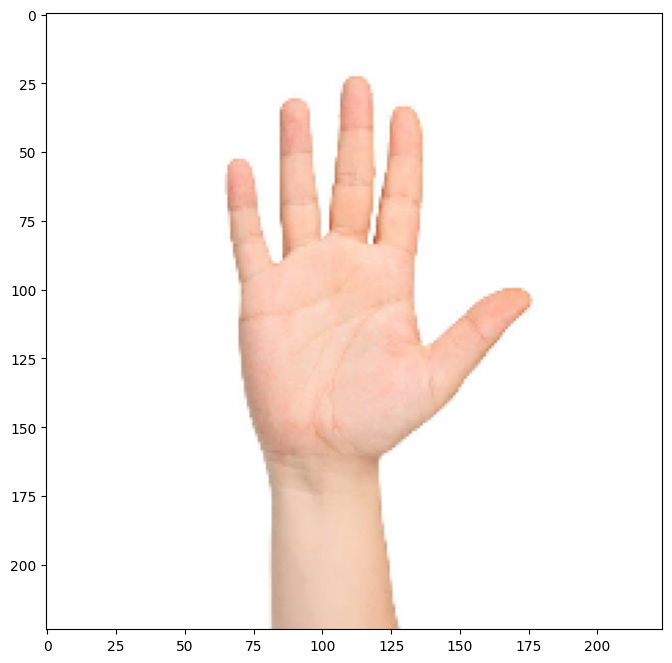

In [15]:
# Load and preprocess sample image
image1 = loadAndPreprocessImage('../../../Dados/imagem01.png')
image2 = loadAndPreprocessImage('../../../Dados/imagem02.png')
printImage(image1)
printImage(image2)

## Carregando o modelo

In [16]:
# Load pretrained classifier
pretrained_model = load_model("../../Dados/keras_model.h5", compile=False)
pretrained_model.trainable = False
decode_predictions = open("../../Dados/labels.txt", "r").readlines()

## Realizando a inferência

1/1 [==============================] - 1s 635ms/step


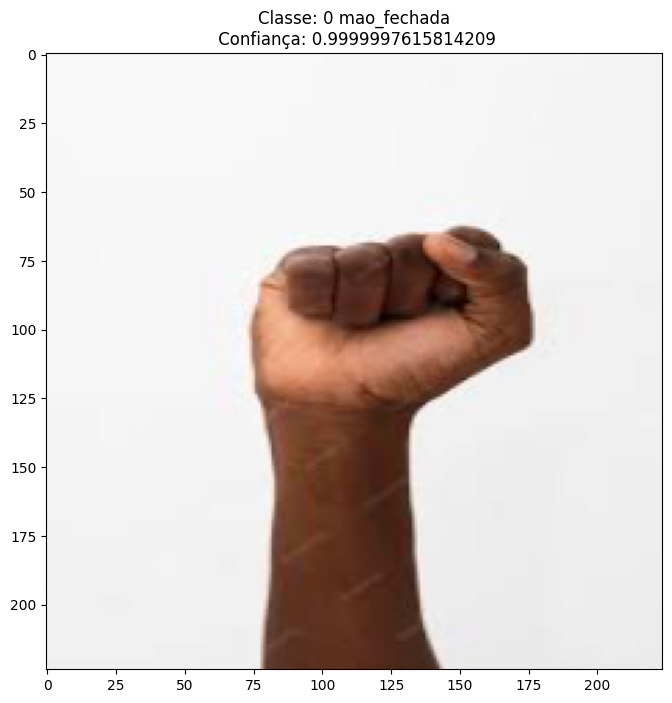

1/1 [==============================] - 0s 23ms/step


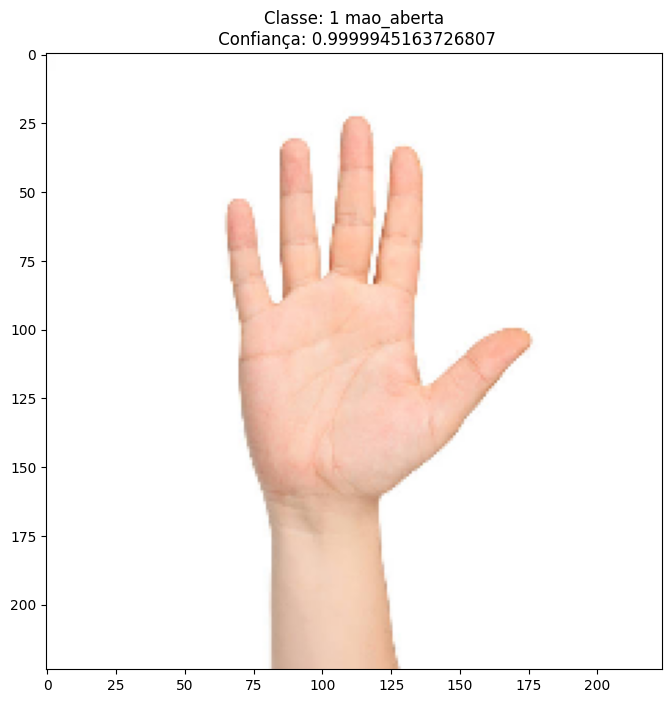

In [17]:
# Classify sample image and print classification result
image_probs, class_name, confidence_score = classifySample(image1, pretrained_model)
# print(image_probs)
printImage(image1, class_name, confidence_score)

image_probs, class_name, confidence_score = classifySample(image2, pretrained_model)
# print(image_probs)
printImage(image2, class_name, confidence_score)

# BlackBox - Adversarial Attacks

## Square Attack

O square attack é um ataque black-box, ou seja, não necessita de acesso à arquitetura, parâmetros e dados de treino para ser executado. O Square Attack precisa apenas de acesso ao score das classes calculado pelo classificador para produzir exemplos adversariais por meio de um processo iterativo.

 O ataque foi pensado para ser utilizado no cenário de redes neurais profundas que têm como entrada imagens, e este fato é importante pois explica o raciocínio por trás do ataque. As redes neurais convolucionais varrem uma imagem, a processando em pequenas janelas de formato quadrado, assim o Square Attack busca perturbar essas redes introduzindo perturbações em forma de quadrados de tamanho e intensidade variados.

Podemos descrever o funcionamento do ataque nos seguintes passos:

1. Gerar uma perturbação aleatória em forma de quadrado com uma localização e intensidade aleatória;
2. Aplicar esta perturbação à imagem;
3. Obter os scores da imagem perturbada;
4. Caso o score da classe correta diminua, manter essa perturbação, caso contrário descartar;
5. Repetir o processo até obter um exemplo adversarial ou atingir um número limite de iterações.

Como parâmetros do Square Attack, temos:

1. eps: Controlar a intensidade da perturbação;
2. initial_p: Controla o tamanho inicial do quadrado, sendo que o tamanho dos quadrados gerados é reduzido com o passar das iterações;
3. n_iters: Quantidade de chamadas ao modelo que serão executadas;
4. initialization: Se uma inicialização será aplicada à imagem.

Assim, alterando os parâmetros é possível obter um ataque que de maneira veloz gere perturbações adversariais bem perceptíveis, ou um ataque mais discreto que precisa de mais iterações para gerar perturbações.

### Classe que implementa o Square Attack.

In [18]:
# adaptado de https://github.com/max-andr/square-attack
# artigo: https://arxiv.org/abs/1912.00049

import numpy as np
from tqdm import tqdm

class SquareAttack:
  def __init__(self,eps,n_iters,initial_p,initialization):
    self.eps = eps
    self.n_iters = n_iters
    self.initial_p = initial_p
    self.initialization = initialization

  # Seleciona o tamanho do quadrado de acordo com a iteração atual
  def p_selection(self,p_init,it,n_iters):
    it = int(it / n_iters * 10000)
    if 10 < it <= 50:
        p = p_init / 2
    elif 50 < it <= 200:
        p = p_init / 4
    elif 200 < it <= 500:
        p = p_init / 8
    elif 500 < it <= 1000:
        p = p_init / 16
    elif 1000 < it <= 2000:
        p = p_init / 32
    elif 2000 < it <= 4000:
        p = p_init / 64
    elif 4000 < it <= 6000:
        p = p_init / 128
    elif 6000 < it <= 8000:
        p = p_init / 256
    elif 8000 < it <= 10000:
        p = p_init / 512
    else:
        p = p_init
    return p

  def apply(self,model,image,y):
    _,h,w,c = image.shape
    n_features = c*h*w

    min_val,max_val = -1,1
    preds = np.array(model.predict(image,verbose=0))[0]
    y_pred = preds.argmax()
    score = preds[y_pred]

    X = image
    if self.initialization:
      init_delta = np.random.choice([-self.eps,self.eps],size=[1,w,c])
      X_best = tf.clip_by_value(image+init_delta,-1,1)
      pert = X_best-image
    else:
      X_best = image
      pert = X_best-image

    preds = np.array(model.predict(X_best,verbose=0))[0]
    y_pred = preds.argmax()

    if y_pred != y:
      return 1,X_best,pert

    score = preds[y_pred]
    loss_min = score

    for i_iter in range(self.n_iters-1):
      to_fool = loss_min >= 0.5

      if to_fool:
        X_curr,X_best_curr = X,X_best
        loss_min_curr = loss_min
        delta = (X_best_curr-X_curr).numpy()
        p = self.p_selection(self.initial_p,i_iter,self.n_iters)
        s = int(round(np.sqrt(p*n_features/c)))
        s = min(max(s,1),h-1)

        # Escolhe um centro aleatório para o quadrado
        center_h = np.random.randint(0,max(h-s,1))
        center_w = np.random.randint(0,max(w-s,1))

        x_curr_window = X_curr[:,center_h:center_h+s,center_w:center_w+s,:]
        X_best_curr_window = X_best_curr[:,center_h:center_h+s,center_w:center_w+s,:]

        # Gera uma perturbação aleatória no quadrado
        delta[:,center_h:center_h+s,center_w:center_w+s,:] = np.random.choice([-self.eps,self.eps],size=[1,1,c])

        X_new = tf.clip_by_value(X_curr+delta,-1,1)

        preds = np.array(model.predict(X_new,verbose=0))[0]
        y_pred = preds.argmax()
        score = preds[y_pred]

        if y_pred != y:
          return i_iter,X_new, (pert+delta)

        if score < loss_min:
          loss_min = score
          X_best = X_new
          pert += delta
    return self.n_iters, X_best,pert

Vamos observar a relação entre imperceptibilidade e velocidade do ataque, para tanto vamos definir duas configurações de parâmetros diferentes. Uma vai produzir perturbações mais perceptíveis que enganam o classificador mais rapidamente. A outra irá produzir perturbações mais discretas que demoram mais para apresentar efeito.

Configuração Discreta
*   eps: 0.035
*   initial_p: 0.5
*   Inicialização: Falso

Configuração Rápida
*   eps: 0.06
*   initial_p: 0.7
*   Inicialização: Verdadeiro

### Square Attack - Configuração Discreta

#### Construindo a Exemplo Adversarial

In [78]:
# For reproductibility
np.random.seed(19)

# Craft adversarial sample
attack = SquareAttack(eps=0.035, n_iters=600, initial_p=0.5, initialization=False)
n_iters, perturbed_image, pert = attack.apply(pretrained_model, image1, 0)
print(f"Número de iterações necessárias: {n_iters}")

Número de iterações necessárias: 600


#### Realizando a classificação do exemplo adversarial

1/1 [==============================] - 0s 24ms/step


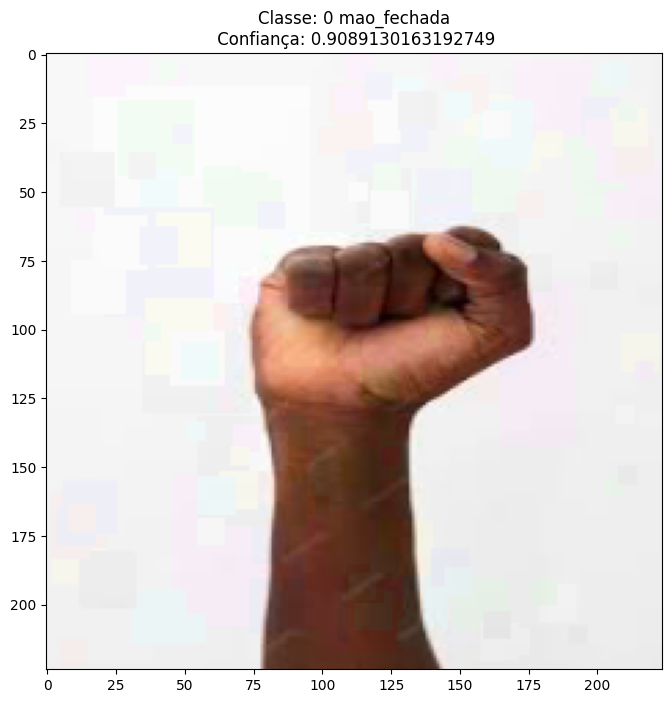

In [79]:
# Classify adversarial sample and print classification result
image_probs, class_name, confidence_score = classifySample(perturbed_image, pretrained_model)
printImage(perturbed_image, class_name, confidence_score)

O resultado foi ruim, dá pra perceber os retângulos a olho nu facilmente, além da predição não ter sido alterada da original. Como esta parte não faz parte da atividade, eu não alterei nada.

#### Exibindo a perturbação adversarial

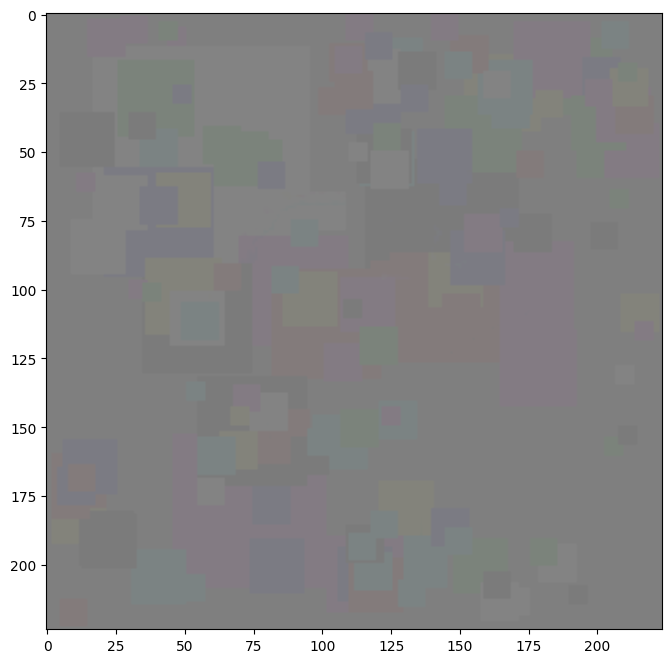

In [80]:
# # Get and print adversarial perturbation
# printImage(pert)  # perturbação total aplicada
printImage(perturbed_image - image1)  # perturbação com clip

### Square Attack - Configuração Rápida

#### Construindo o Exemplo Adversarial

Testei **DIVERSAS** combinações de parâmetros, nenhuma funcionou, o "melhor" resultado que eu tive, foi este abaixo, eu não sei se meu modelo está muito bem treinado, ou se fiz um ataque ruim, porém, visto que o ataque preparado antes da atividade também não conseguiu, então realmente não sei.

Os "melhores" parâmetros foram:

EPS: 0.5

N_ITERS: 600

INITIAL_P: 0.6

Em EPSs muito baixos, o modelo errava completamente, a medida que fui aumentando, os resultados da imagem1 foram melhorando, mas não obtive muito progresso com a imagem2. O parâmetro Initial_P se mostrou gerar resultados bem aleatórios, não consegui ver um padrão de acrésimo ou decréscimo. O Initialization eu preferi deixar como True, para aumentar a velocidade, visto que ele já começa com uma perturbação aleatória.

In [161]:
# For reproductibility
np.random.seed(19)

# Craft adversarial sample
attack = SquareAttack(eps=0.5, n_iters=600, initial_p=0.6, initialization=True)

n_iters_1, perturbed_image_1, pert_1 = attack.apply(pretrained_model, image1, 0)
print(f"Número de iterações necessárias: {n_iters_1}")
n_iters_2, perturbed_image_2, pert_2 = attack.apply(pretrained_model, image2, 0)
print(f"Número de iterações necessárias: {n_iters_2}")

Número de iterações necessárias: 1
Número de iterações necessárias: 1


#### Realizando a classificação do exemlo adversarial

1/1 [==============================] - 0s 24ms/step


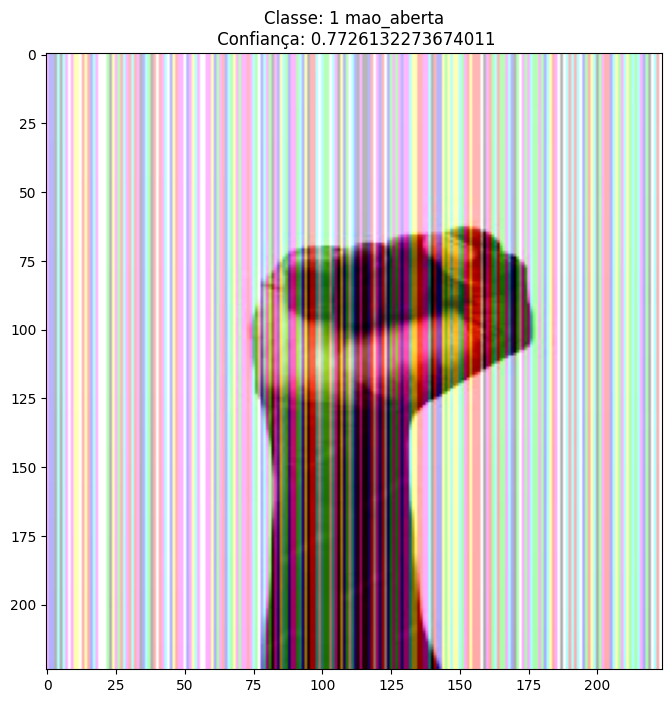

1/1 [==============================] - 0s 24ms/step


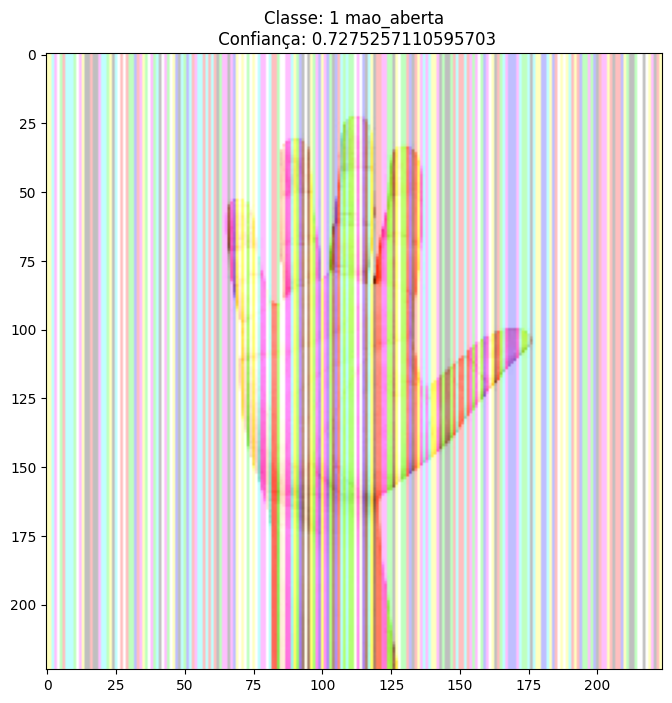

In [162]:
# Classify adversarial sample and print classification result
image_probs_1, class_name_1, confidence_score_1 = classifySample(perturbed_image_1, pretrained_model)
printImage(perturbed_image_1, class_name_1, confidence_score_1)
image_probs_2, class_name_2, confidence_score_2 = classifySample(perturbed_image_2, pretrained_model)
printImage(perturbed_image_2, class_name_2, confidence_score_2)

#### Exibindo a perturbação adversarial

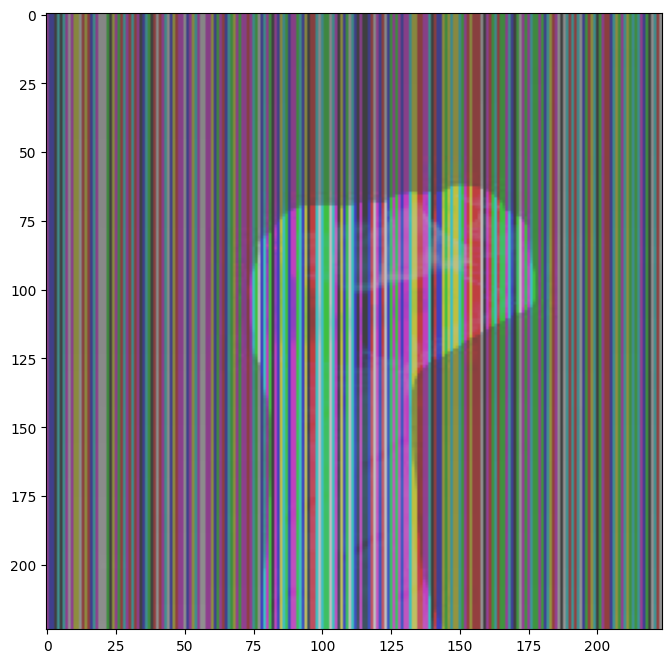

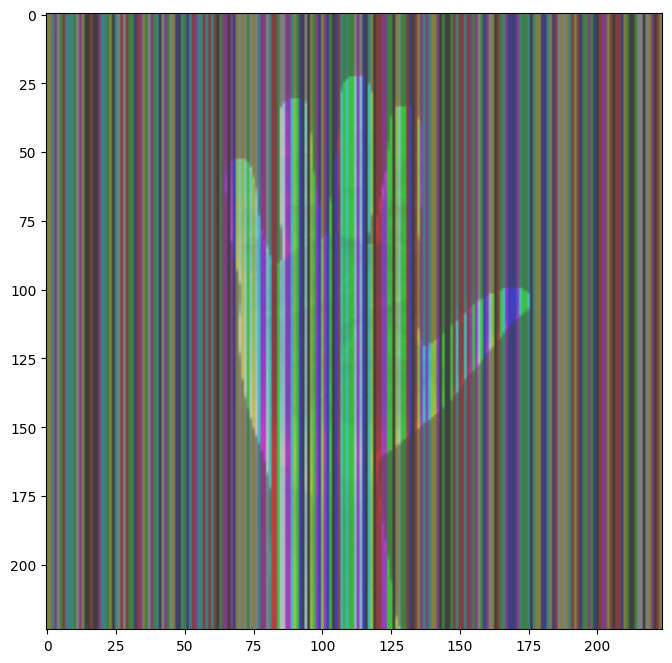

In [164]:
# # Get and print adversarial perturbation
# printImage(pert)  # perturbação total aplicada
printImage(perturbed_image_1 - image1)  # perturbação com clip
printImage(perturbed_image_2 - image2)  # perturbação com clip

## SimBA

O simBA (Simple Black Box Attack) também é um ataque iterativo baseado em score, com algumas diferenças em relação ao Square Attack. A intuição do simBA é baseada em obter ruídos retirados de direções ortnormais e então tentar adcionar esses ruídos à imagem. Um exemplos do que são essas direções ortonormais, é o espaço dos pixels da imagem, ou seja, cada perturbação seria aplicada à um único pixel.

A implementação adaptada abaixo leva em conta que para imagens de tamanho razoável, a alteração de um único pixel não é capaz de produzir variações grandes o suficiente no score. Assim a solução é utilizar blocos de pixels maiores como direção ortornomal.

Outro ponto, é que foi observado experimentalmente que perturbações em padrão de baixa frequência tem tendência adversarial em comparação à um padrão uniforme ou completamente aleatório. Portanto os padrões gerados são baseados em perturbações de baixa frequência.

Assim podemos descrever o algoritmo do simBA:

1. Retirar um vetor de uma base ortonormal;
2. Adcionar este vetor à imagem atual;
3. Caso o score da classe correta diminua, adotar esta perturbação;
4. Caso contrário, experimentar subtrair o vetor da imagem, caso o score diminua, adotar esta perturbação;
5. Repetir o processo até obter uma imagem adversarial ou atingir um limite de iterações.

Os parâmetros do simBA são:

1. epsilon: intensidade da perturbação.
2. block_size: tamanho do bloco a ser aplicado cada perturbação.
3. n_iters: número de iterações.

### Classe que implementa o SimBA

In [51]:
# adaptado de https://github.com/cg563/simple-blackbox-attack/blob/master/simba.py
# artigo: https://arxiv.org/abs/1905.07121

from scipy.fftpack import dctn,idctn


class simBA:

  def __init__(self,epsilon,n_iters):
    self.epsilon = epsilon
    self.n_iters = n_iters

  def apply(self,image,y,model,block_size=8):
    _,h,w,c = image.shape

    # é necessário que as dimensões da imagem sejam múltiplas de block_size
    new_h = h+block_size-h%block_size
    new_w = w+block_size-w%block_size
    resized_x = np.zeros((1,new_h,new_w,c))
    resized_x[:,:h,:w,:] = image
    resized_x = tf.convert_to_tensor(resized_x)

    min_val, max_val = -1,1

    n_dims = int((new_h*new_w*c)/(block_size**2))

    perm = np.random.permutation(n_dims)

    preds = np.array(model.predict(image,verbose=0))[0]
    y_pred = preds.argmax()
    score = preds[y_pred]

    loss_min = score
    x_best = resized_x

    n_queries = 1
    iteration_index = 1

    for i in range(min(n_dims,self.n_iters)):
      # o bloco de perturbação é gerado no domínio da transformada do cosseno e então levado para o domínio das imagens
      diff = np.zeros((block_size*block_size))
      diff = np.reshape(diff,(block_size,block_size))
      pert = np.random.choice(np.arange(-self.epsilon,self.epsilon),4)
      diff[:2,:2] = np.reshape(pert,(2,2))
      noise_block = idctn(diff,norm='ortho')

      index = perm[i]
      channel_index = int(index//((new_h*new_w)/(block_size**2)))
      remaining_index = index - channel_index*((new_h*new_w)/block_size**2)
      row_index = int(remaining_index // (new_w/block_size))
      col_index = int((remaining_index-row_index*(new_w/block_size)))

      x_new = x_best.numpy()
      x_new[:,row_index*block_size:(row_index+1)*block_size,col_index*block_size:(col_index+1)*block_size,channel_index] = (x_new[:,row_index*block_size:(row_index+1)*block_size,col_index*block_size:(col_index+1)*block_size,channel_index]+noise_block).clip(min_val,max_val)

      x_new_cropped = x_new[:,:h,:w,:]

      preds = np.array(model.predict(x_new_cropped,verbose=0))[0]
      y_pred = preds.argmax()
      score = preds[y_pred]

      if y_pred != y:
        return n_queries,x_new_cropped

      n_queries += 1
      # caso a adição de ruído piore o score da classe
      if score < loss_min:
        x_best = tf.convert_to_tensor(x_new)
        loss_min = score
      else:
        if n_queries >= self.n_iters:
          break

        x_new = x_best.numpy()
        # caso contrário investigamos a subtração
        x_new[:,row_index*block_size:(row_index+1)*block_size,col_index*block_size:(col_index+1)*block_size,channel_index] = (x_new[:,row_index*block_size:(row_index+1)*block_size,col_index*block_size:(col_index+1)*block_size,channel_index]-noise_block).clip(min_val,max_val)

        x_new_cropped = x_new[:,:h,:w,:]
        preds = np.array(model.predict(x_new_cropped,verbose=0))[0]
        y_pred = preds.argmax()
        score = preds[y_pred]

        if y_pred != y:
          return n_queries,x_new_cropped

        n_queries += 1

        if score < loss_min:
          x_best = tf.convert_to_tensor(x_new)
          loss_min = score

      if n_queries >= self.n_iters:
        break
    return self.n_iters,x_best[:,:h,:w,:c]

### Ataque Discreto

Também obtive um resultado muito ruim, nenhum resultado se mostrou bom mesmo testando vários parâmetros. Não entendi o motivo da quantidade de queries entre as duas imagens serem a maior possível(mínimo vs máximo).

Os parâmetros foram:

EPSILON: 0.1

N_ITERS: 600

#### Criando o Exemplo Adversarial

In [179]:
# For reproductibility
np.random.seed(19)

# Craft adversarial sample
simba_attack = simBA(epsilon=0.1, n_iters=600)

n_queries_1, perturbed_image_simba_1 = simba_attack.apply(image1, 0, pretrained_model)
print(f"Número de consultas necessárias: {n_queries_1}")

n_queries_2, perturbed_image_simba_2 = simba_attack.apply(image2, 0, pretrained_model)
print(f"Número de consultas necessárias: {n_queries_2}")

Número de consultas necessárias: 600
Número de consultas necessárias: 1


#### Realizando a classificação do exemplo adversarial

1/1 [==============================] - 0s 22ms/step


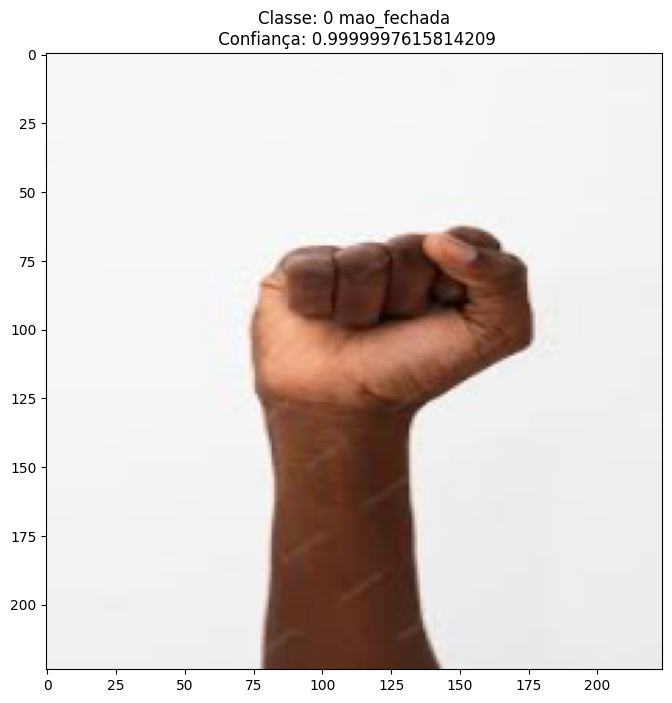

1/1 [==============================] - 0s 22ms/step


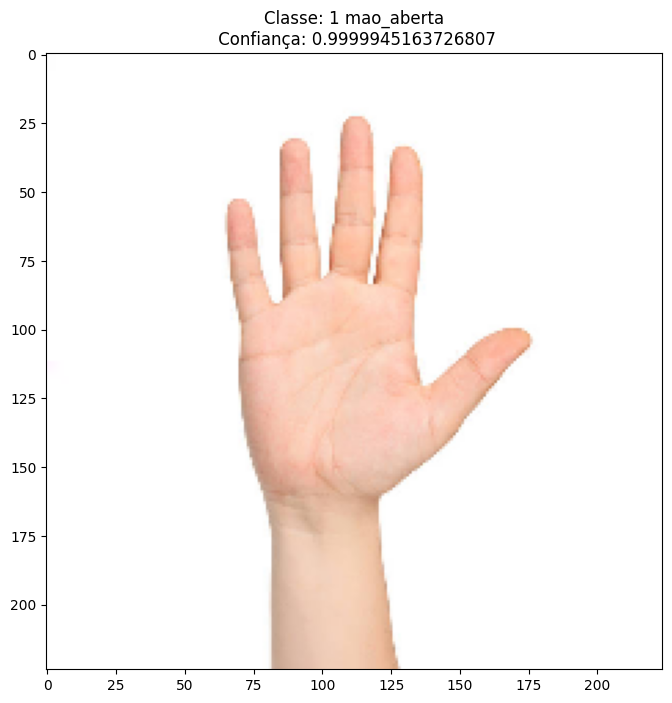

In [180]:
# Classify adversarial sample and print classification result for SimBA
image_probs_simba_1, class_name_simba_1, confidence_score_simba_1 = classifySample(perturbed_image_simba_1, pretrained_model)
printImage(perturbed_image_simba_1, class_name_simba_1, confidence_score_simba_1)

image_probs_simba_2, class_name_simba_2, confidence_score_simba_2 = classifySample(perturbed_image_simba_2, pretrained_model)
printImage(perturbed_image_simba_2, class_name_simba_2, confidence_score_simba_2)

### Ataque Rápido

Continuei tendo um resultado muito ruim, e novamente estou tendo o problema da quantidade de queries estar sendo muito diferente.

Os parâmetros foram:

EPSILON: 0.9

N_ITERS: 40

Tentei forçar um EPSILON muito alto, e mesmo assim não obetive sucesso em nenhuma das duas imagens, e o N_ITERS não influenciou muito no resultado.

#### Criando o Exemplo Adversarial

In [188]:
# For reproductibility
np.random.seed(19)

# Craft adversarial sample
simba_attack = simBA(epsilon=0.9, n_iters=40)

n_queries_1, perturbed_image_simba_1 = simba_attack.apply(image1, 0, pretrained_model)
print(f"Número de consultas necessárias: {n_queries_1}")

n_queries_2, perturbed_image_simba_2 = simba_attack.apply(image2, 0, pretrained_model)
print(f"Número de consultas necessárias: {n_queries_2}")

Número de consultas necessárias: 40
Número de consultas necessárias: 1


#### Realizando a classificação do exemplo adversarial

1/1 [==============================] - 0s 24ms/step


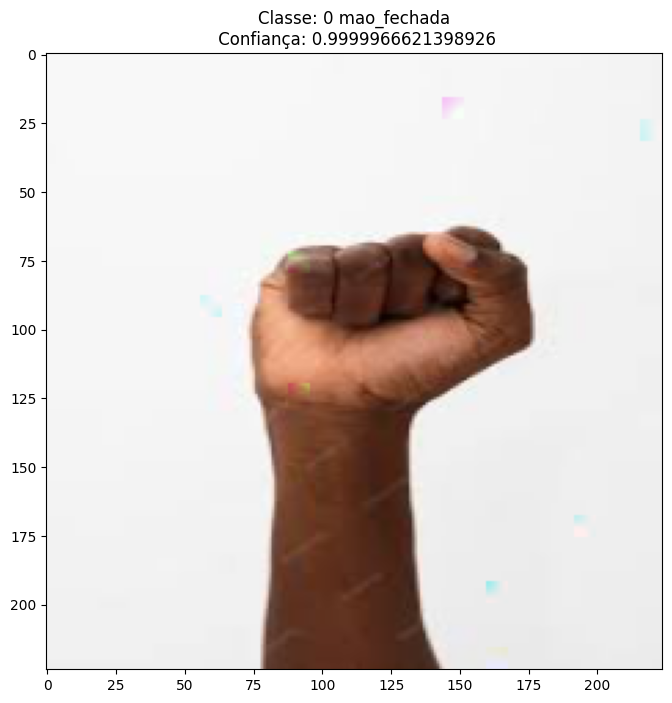

1/1 [==============================] - 0s 26ms/step


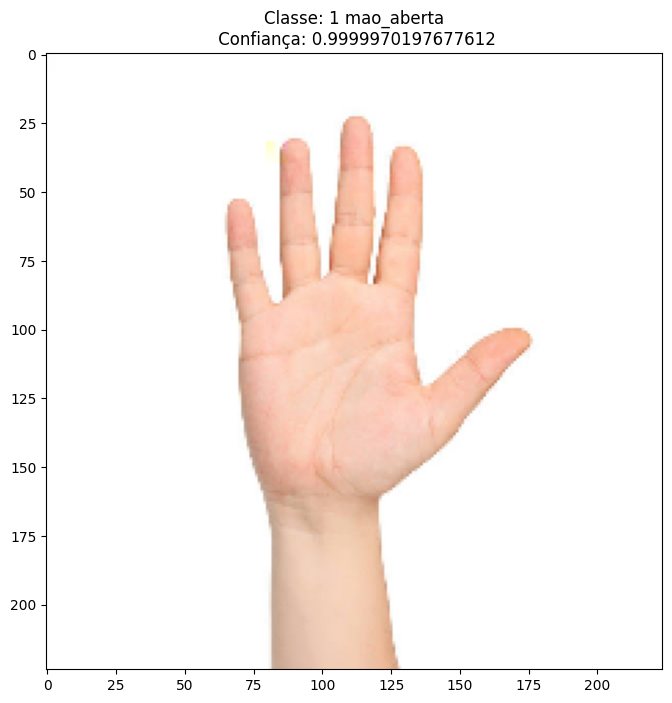

In [189]:
# Classify adversarial sample and print classification result for SimBA
image_probs_simba_1, class_name_simba_1, confidence_score_simba_1 = classifySample(perturbed_image_simba_1, pretrained_model)
printImage(perturbed_image_simba_1, class_name_simba_1, confidence_score_simba_1)

image_probs_simba_2, class_name_simba_2, confidence_score_simba_2 = classifySample(perturbed_image_simba_2, pretrained_model)
printImage(perturbed_image_simba_2, class_name_simba_2, confidence_score_simba_2)

### Pior Teste

Devido aos resultados péssimos anteriormente, decidi testar o pior cenário de todos, alto EPSILON e alto N_ITERS.

Consegui um resultado bem melhor na imagem1, porém, nada mudou na imagem2, mas com certeza este é um ataque com praticamente nada de descrição e também é lento. A diferença entre queries foi grande, mas pelo menos não foi de máximo e mínimo como antes. Eu não sei se tem algo de errado com as imagens ou se meu modelo está muito bem treinado.

#### Criando o Exemplo Adversarial

In [190]:
# For reproductibility
np.random.seed(19)

# Craft adversarial sample
simba_attack = simBA(epsilon=0.99, n_iters=700)

n_queries_1, perturbed_image_simba_1 = simba_attack.apply(image1, 0, pretrained_model)
print(f"Número de consultas necessárias: {n_queries_1}")

n_queries_2, perturbed_image_simba_2 = simba_attack.apply(image2, 0, pretrained_model)
print(f"Número de consultas necessárias: {n_queries_2}")

Número de consultas necessárias: 431
Número de consultas necessárias: 1


#### Realizando a classificação do exemplo adversarial

1/1 [==============================] - 0s 25ms/step


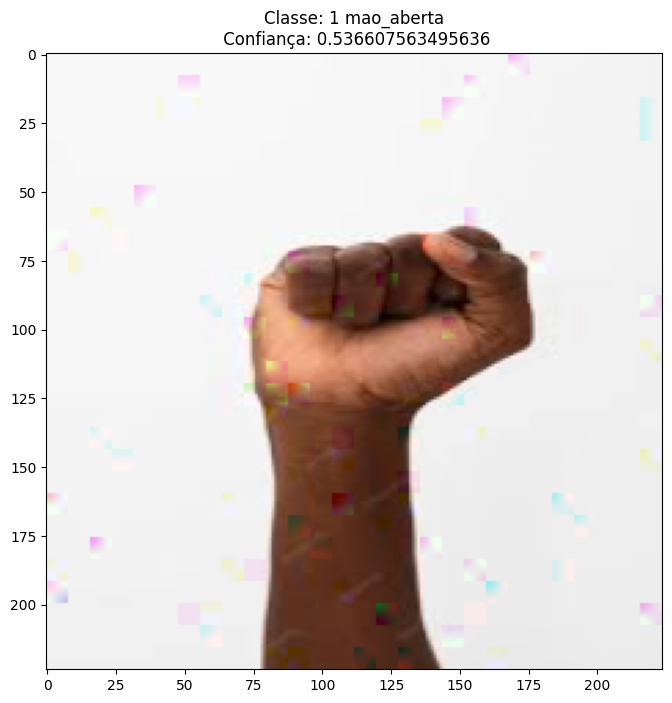

1/1 [==============================] - 0s 24ms/step


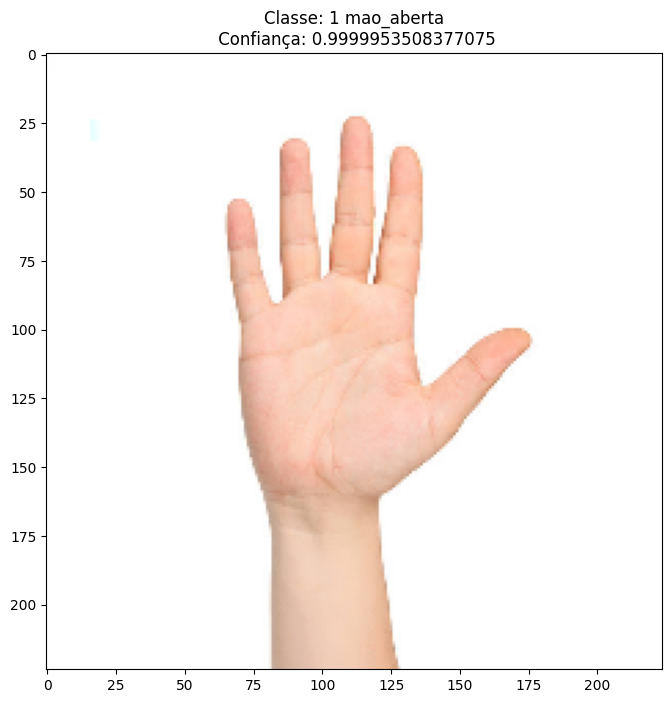

In [191]:
# Classify adversarial sample and print classification result for SimBA
image_probs_simba_1, class_name_simba_1, confidence_score_simba_1 = classifySample(perturbed_image_simba_1, pretrained_model)
printImage(perturbed_image_simba_1, class_name_simba_1, confidence_score_simba_1)

image_probs_simba_2, class_name_simba_2, confidence_score_simba_2 = classifySample(perturbed_image_simba_2, pretrained_model)
printImage(perturbed_image_simba_2, class_name_simba_2, confidence_score_simba_2)